In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from utils import SHIPS_ML_model_funcs
from utils import SHIPS_plotting
import matplotlib.colors
import os

##### Experiment info for both models

In [2]:
fpath_load = 'DATA/ML_model_results/TRAINING/'
train_yr_start = 2005
train_yr_end = 2018
mask_TYPE = 'SIMPLE'
is_stand = True
if is_stand:
    stand_str = 'STANDARDIZED'
else:
    stand_str = 'no_STANDARD'
RI_thresh = 30
wts_str = 'default'
score = 'f1_weighted'
N_samples = 15

##### RF experiment info

In [3]:
RF_crit = 'gini'
RF_path_suff = 'OLD_FUNCS_TRAIN_{RF_crit}_SHIPS_SIMPLE_RI_vs_no_RI_{train_yr_start}-{train_yr_end}_{mask_TYPE}_MASK_'\
'{stand_str}_RI_thresh_{RI_thresh}weights_{wts_str}_wts_{N_samples}_samples_{score}.csv'.format(RF_crit=RF_crit,
                           train_yr_start=train_yr_start,train_yr_end=train_yr_end,mask_TYPE=mask_TYPE,
                           stand_str=stand_str,RI_thresh=RI_thresh,wts_str=wts_str,N_samples=N_samples,score=score)

##### RF Oversampling info


In [4]:
RF_path_suff_ov = 'OLD_FUNCS_TRAIN_OVERSAMPLE_{RF_crit}_SHIPS_SIMPLE_RI_vs_no_RI_{train_yr_start}-{train_yr_end}_{mask_TYPE}_MASK_'\
'{stand_str}_RI_thresh_{RI_thresh}weights_{wts_str}_{N_samples}_samples_{score}.csv'.format(RF_crit=RF_crit,
                           train_yr_start=train_yr_start,train_yr_end=train_yr_end,mask_TYPE=mask_TYPE,
                           stand_str=stand_str,RI_thresh=RI_thresh,wts_str='None',N_samples=N_samples,score=score)

##### LR experiment info
We'll just use `lbfgs` since it's so similar to `sag` \ `saga`

In [5]:
LR_model = 'lbfgs'
LR_path_suff = 'TRAIN_{LR_model}_SHIPS_SIMPLE_RI_vs_no_RI_{train_yr_start}-{train_yr_end}_{mask_TYPE}_MASK_'\
'{stand_str}_RI_thresh_{RI_thresh}weights_{wts_str}_wts_{N_samples}_samples_{score}.csv'.format(LR_model=LR_model,
                           train_yr_start=train_yr_start,train_yr_end=train_yr_end,mask_TYPE=mask_TYPE,
                           stand_str=stand_str,RI_thresh=RI_thresh,wts_str=wts_str,N_samples=N_samples,score=score)

#### Part 1. Plots from confusion matrix
We can make several plots with our confusion matrix results:
* Performance diagram for training data
* Box plots of PoD, FAR, CSI; Hits, and Misses

In [6]:
cm_RF = pd.read_csv(fpath_load+'RF/Conf_Matrix'+RF_path_suff)
cm_RF['Model'] = 'Random Forest (class wt)'
#
cm_RF_ov = pd.read_csv(fpath_load+'RF/Conf_Matrix'+RF_path_suff_ov)
cm_RF_ov['Model'] = 'Random Forest (oversampling)'

#
cm_LR = pd.read_csv(fpath_load+'LOGISTIC/Conf_Matrix'+LR_path_suff)
cm_LR['Model'] = 'Logistic Reg.'
cm_res = pd.concat([cm_RF,cm_RF_ov,cm_LR])


In [55]:
cm_res.groupby(['Category Names','BASIN','Model']).median().xs('RI')

Unnamed: 0       POD        SR  \
BASIN        Model                                                          
ALL          Logistic Reg.                          1  0.771028  0.398760   
             Random Forest (class wt)               1  0.609524  0.529762   
             Random Forest (oversampling)           1  0.689655  0.504098   
ATLANTIC     Logistic Reg.                          1  0.452381  0.368421   
             Random Forest (class wt)               1  0.363636  0.647059   
             Random Forest (oversampling)           1  0.387097  0.444444   
EAST_PACIFIC Logistic Reg.                          1  0.830508  0.413043   
             Random Forest (class wt)               1  0.616667  0.488889   
             Random Forest (oversampling)           1  0.717949  0.512397   
SOUTHERN_HEM Logistic Reg.                          1  0.783133  0.360902   
             Random Forest (class wt)               1  0.562500  0.484375   
             Random Forest (oversampling)           1  0.675325  0.480392   
WEST_PACIFIC Logistic Reg.                          1  0.864286  0.450199   
             Random Forest (class wt)               1  0.732283  0.591241   
             Random Forest (oversampling)           1  0.772152  0.524194   

                                           N_actual    Threat  Hits  \
BASIN        Model                                                    
ALL          Logistic Reg.                      256  0.358098   192   
             Random Forest (class wt)           285  0.398664   181   
             Random Forest (oversampling)       309  0.407317   201   
ATLANTIC     Logistic Reg.                       39  0.250000    16   
             Random Forest (class wt)            43  0.250000    11   
             Random Forest (oversampling)        29  0.260870    12   
EAST_PACIFIC Logistic Reg.                       45  0.377953    39   
             Random Forest (class wt)            61  0.349057    37   
             Random Forest (oversampling)        62  0.420000    42   
SOUTHERN_HEM Logistic Reg.                       72  0.317757    54   
             Random Forest (class wt)            73  0.320755    39   
             Random Forest (oversampling)        77  0.392157    52   
WEST_PACIFIC Logistic Reg.                       89  0.418182    80   
             Random Forest (class wt)           114  0.482955    84   
             Random Forest (oversampling)       128  0.440909    93   

                                           False Alarms  Correct Negs  \
BASIN        Model                                                      
ALL          Logistic Reg.                          286           632   
             Random Forest (class wt)               158           822   
             Random Forest (oversampling)           202           715   
ATLANTIC     Logistic Reg.                           21           189   
             Random Forest (class wt)                14           202   
             Random Forest (oversampling)            14           150   
EAST_PACIFIC Logistic Reg.                           66           121   
             Random Forest (class wt)                40           169   
             Random Forest (oversampling)            43           133   
SOUTHERN_HEM Logistic Reg.                          103           186   
             Random Forest (class wt)                40           204   
             Random Forest (oversampling)            53           201   
WEST_PACIFIC Logistic Reg.                           95           143   
             Random Forest (class wt)                58           210   
             Random Forest (oversampling)            80           189   

                                               PFOD  N_predicted  ...  \
BASIN        Model                                                ...   
ALL          Logistic Reg.                 0.320388          469  ...   
             Random Forest (class wt)      0.170157          336

##### Performance diagram.  
This plot summarizes our results for the training data. For our bootstrapped training data, we show the median false alarm ratio / probability of detection values as well as a 95% confidence interval (error bars). It also shows us our results in the context of frequency bias (diagonal lines; are we over/underforecasting our event?) and critical success index (contours), which is another metric that summarizes hits, misses, and false alarms all together.  

In [7]:
fig_dir_save = 'Figures/TRAINING/'
if not os.path.exists(fig_dir_save):
    os.makedirs(fig_dir_save)

/home/mmcgraw/miniconda3/envs/SHIPS/lib/python3.9/site-packages/IPython/core/interactiveshell.py:2947: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)


,Unnamed: 0,POD,SR,N_actual,Threat,Hits,False Alarms,Correct Negs,PFOD,N_predicted,...,FAR,Misses,BIAS,Max Depth,Max Features,N Estimators,Min Samples Leaf,Max Iter,Fold,C
Model,,,,,,,,,,,,,,,,,,,,,
Logistic Reg.,1,0.864286,0.450199,89,0.418182,80,95,143,0.391753,172,...,0.549801,13,1.931507,NaN,NaN,NaN,NaN,100.0,7,0.1
Random Forest (class wt),1,0.732283,0.591241,114,0.482955,84,58,210,0.212454,143,...,0.408759,31,1.247706,11.0,4.0,250.0,2.0,NaN,7,NaN
Random Forest (oversampling),1,0.772152,0.524194,128,0.440909,93,80,189,0.275862,169,...,0.475806,33,1.362903,8.0,5.0,200.0,10.0,NaN,7,NaN


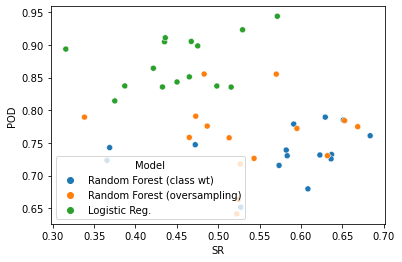

In [8]:
foo = cm_res.set_index(['Category Names','BASIN','Model']).xs(('RI','WEST_PACIFIC')).reset_index()
sns.scatterplot(data=foo,x='SR',y='POD',hue='Model')
foo.groupby('Model').median()

/local/home/mmcgraw/ML_for_TC_RI/utils/SHIPS_plotting.py:214: UserWarning: The following kwargs were not used by contour: 'axes'
  plt.contourf(success_ratio_matrix, pod_matrix, csi_matrix,
/local/home/mmcgraw/ML_for_TC_RI/utils/SHIPS_plotting.py:229: UserWarning: The following kwargs were not used by contour: 'axes'
  bias_contour_object = plt.contour(


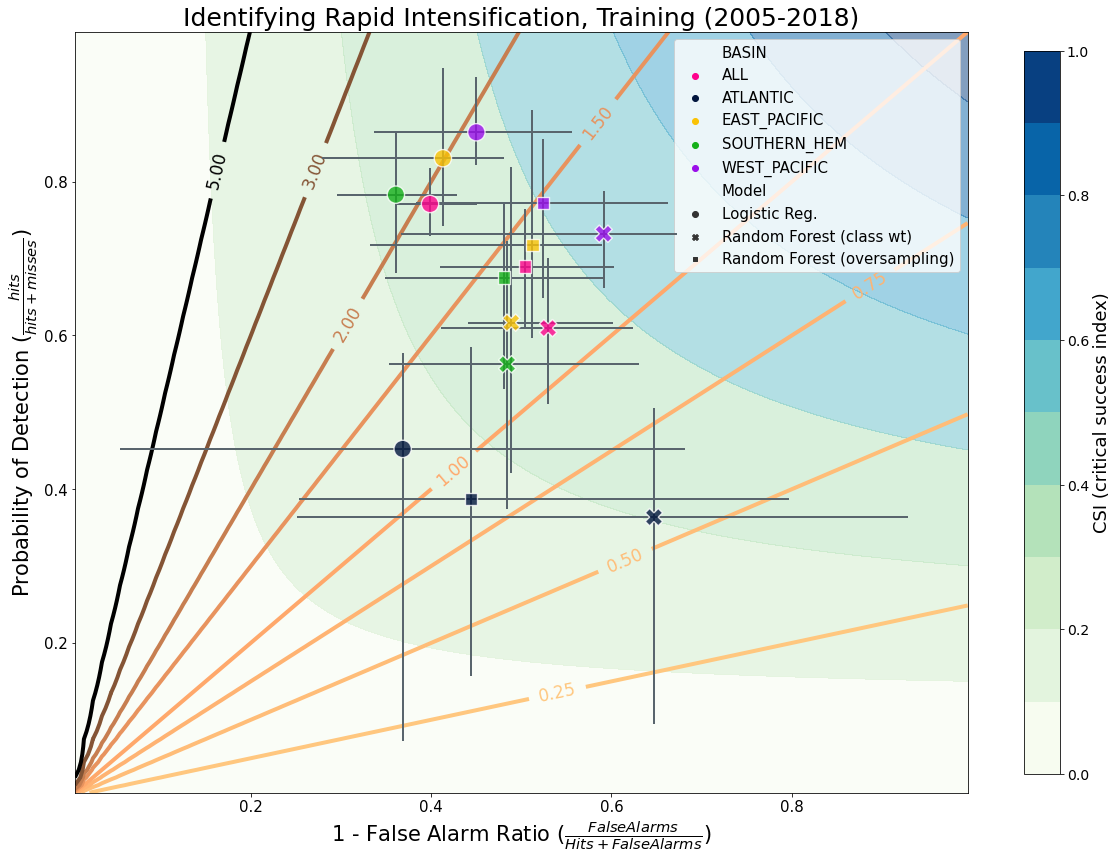

In [9]:
fig1,ax1 = plt.subplots(1,1,figsize=(20,14))
SHIPS_plotting.make_performance_diagram_background(ax1)
# Save empty PD in case we ever need it for a presentation
fig1.savefig(fig_dir_save+'perf_diag_empty.png',format='png',dpi=350,bbox_inches='tight')
fig1.savefig(fig_dir_save+'perf_diag_empty.pdf',format='pdf',bbox_inches='tight')
# Now, add results to PD
SHIPS_plotting.add_model_results(ax1,cm_res)
ax1.set_title('Identifying Rapid Intensification, Training (2005-2018)',fontsize=25)
#
fig1.savefig(fig_dir_save+'perf_diag_TRAINING.png',format='png',dpi=350,bbox_inches='tight')
fig1.savefig(fig_dir_save+'perf_diag_TRAINING.pdf',format='pdf',bbox_inches='tight')

##### Get baseline
$$ Baseline = \frac{N_{yes}}{N_{yes} + N_{no}} $$

In [10]:
cm_group = cm_res.groupby(['BASIN','Model','Category Names','Fold']).mean()
baselines = cm_group.xs('RI',level=2)['N_actual']/cm_group.xs('not RI',level=2)['N_actual']

##### Get bias
$$ Bias = \frac{Hits + False Alarms}{Hits + Misses}$$

In [11]:
cm_res['BIAS'] = (cm_res['Hits']+cm_res['False Alarms'])/(cm_res['Hits'] + cm_res['Misses'])
basin_ALL = cm_res['BASIN'].unique().tolist()

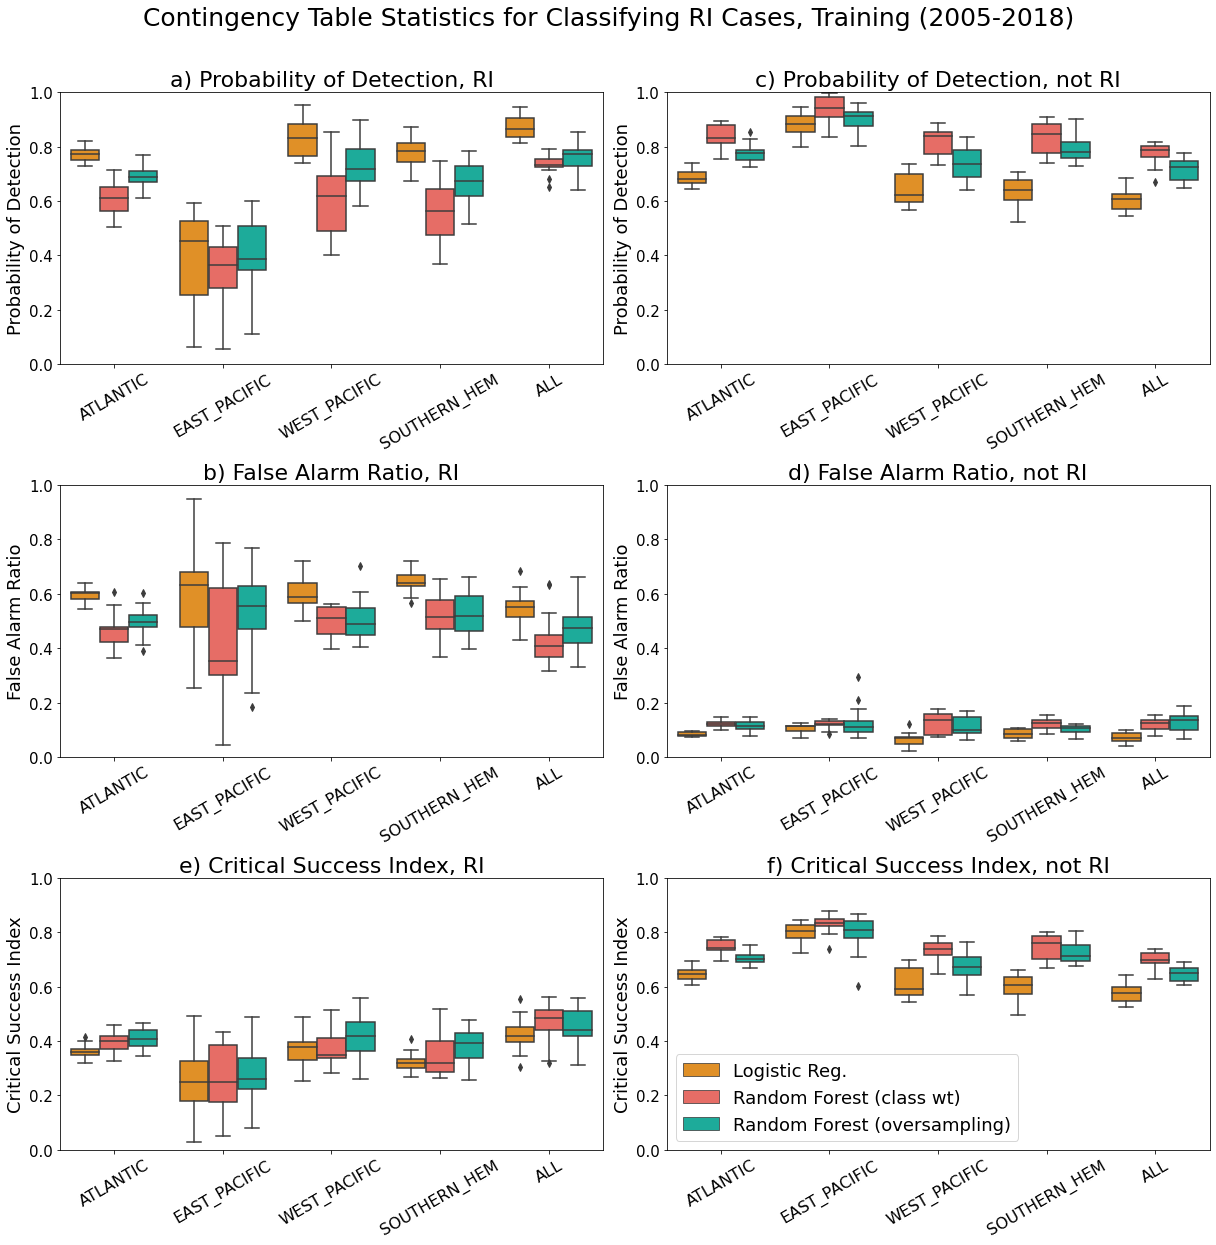

In [22]:
fig6,((ax6a,ax6b),(ax6c,ax6d),(ax6e,ax6f)) = plt.subplots(3,2,figsize=(17,17))
pal_2 = sns.set_palette({'xkcd:turquoise','xkcd:coral','xkcd:tangerine'})
cm_plt = cm_res.set_index(['Category Names'])
cm_plt_total = cm_plt.reset_index().groupby(['Category Names','BASIN','Model','Fold']).mean()
#cm_plt_norm = 
sns.boxplot(data=cm_plt_total.xs('RI').sort_values(['BASIN','Model']).reset_index(),x='BASIN',y='POD',hue='Model',ax=ax6a)
ax6a.set_ylabel('Probability of Detection',fontsize=18)
ax6a.get_legend().remove()
# ax6a.legend(fontsize=12)
ax6a.set_xticklabels(basin_ALL,fontsize=16,rotation=30)
ax6a.set_title('a) Probability of Detection, RI',fontsize=22)
ax6a.set_xlabel(None)
ax6a.set_ylim([0,1])
ax6a.tick_params(axis='y',labelsize=15)
#
sns.boxplot(data=cm_plt.xs('RI').sort_values(['BASIN','Model']).reset_index(),x='BASIN',y='FAR',hue='Model',ax=ax6c)
ax6c.set_ylabel('False Alarm Ratio',fontsize=18)
ax6c.legend(fontsize=12)
ax6c.get_legend().remove()
ax6c.set_xticklabels(basin_ALL,fontsize=16,rotation=30)
ax6c.set_title('b) False Alarm Ratio, RI',fontsize=22)
ax6c.set_xlabel(None)
ax6c.set_ylim([0,1])
ax6c.tick_params(axis='y',labelsize=15)
#
sns.boxplot(data=cm_plt.xs('not RI').sort_values(['BASIN','Model']).reset_index(),
            x='BASIN',y='POD',hue='Model',ax=ax6b)
ax6b.set_ylabel('Probability of Detection',fontsize=18)
ax6b.legend(fontsize=12)
ax6b.get_legend().remove()
ax6b.set_xticklabels(basin_ALL,fontsize=16,rotation=30)
ax6b.set_title('c) Probability of Detection, not RI',fontsize=22)
ax6b.set_xlabel(None)
ax6b.tick_params(axis='y',labelsize=15)
ax6b.set_ylim([0,1])
#
sns.boxplot(data=cm_plt.xs('not RI').sort_values(['BASIN','Model']).reset_index(),
            x='BASIN',y='FAR',hue='Model',ax=ax6d)
ax6d.set_ylabel('False Alarm Ratio',fontsize=18)
# ax6d.legend(fontsize=18)
ax6d.get_legend().remove()
ax6d.set_xticklabels(basin_ALL,fontsize=16,rotation=30)
ax6d.set_title('d) False Alarm Ratio, not RI',fontsize=22)
ax6d.set_xlabel(None)
ax6d.tick_params(axis='y',labelsize=15)
ax6d.set_ylim([0,1])
#
sns.boxplot(data=cm_plt.xs('RI').sort_values(['BASIN','Model']).reset_index(),
            x='BASIN',y='Threat',hue='Model',ax=ax6e)
ax6e.set_ylabel('Critical Success Index',fontsize=18)
#ax6e.legend(fontsize=18)
ax6e.get_legend().remove()
ax6e.set_xticklabels(basin_ALL,fontsize=16,rotation=30)
ax6e.set_title('e) Critical Success Index, RI',fontsize=22)
ax6e.set_xlabel(None)
ax6e.tick_params(axis='y',labelsize=15)
ax6e.set_ylim([0,1])
#
sns.boxplot(data=cm_plt.xs('not RI').sort_values(['BASIN','Model']).reset_index(),
            x='BASIN',y='Threat',hue='Model',ax=ax6f)
ax6f.set_ylabel('Critical Success Index',fontsize=18)
ax6f.legend(fontsize=18)
ax6f.set_xticklabels(basin_ALL,fontsize=16,rotation=30)
ax6f.set_title('f) Critical Success Index, not RI',fontsize=22)
ax6f.set_xlabel(None)
ax6f.tick_params(axis='y',labelsize=15)
ax6f.set_ylim([0,1])
#
fig6.suptitle('Contingency Table Statistics for Classifying RI Cases, Training (2005-2018)',fontsize=25,y=1.015)
fig6.tight_layout()
#
fig6.savefig(fig_dir_save+'POD_FAR_CSI_TRAINING.png',format='png',dpi=350,bbox_inches='tight')
fig6.savefig(fig_dir_save+'POD_FAR_CSI_TRAINING.pdf',format='pdf',bbox_inches='tight')

##### Hits, Misses, False Alarms

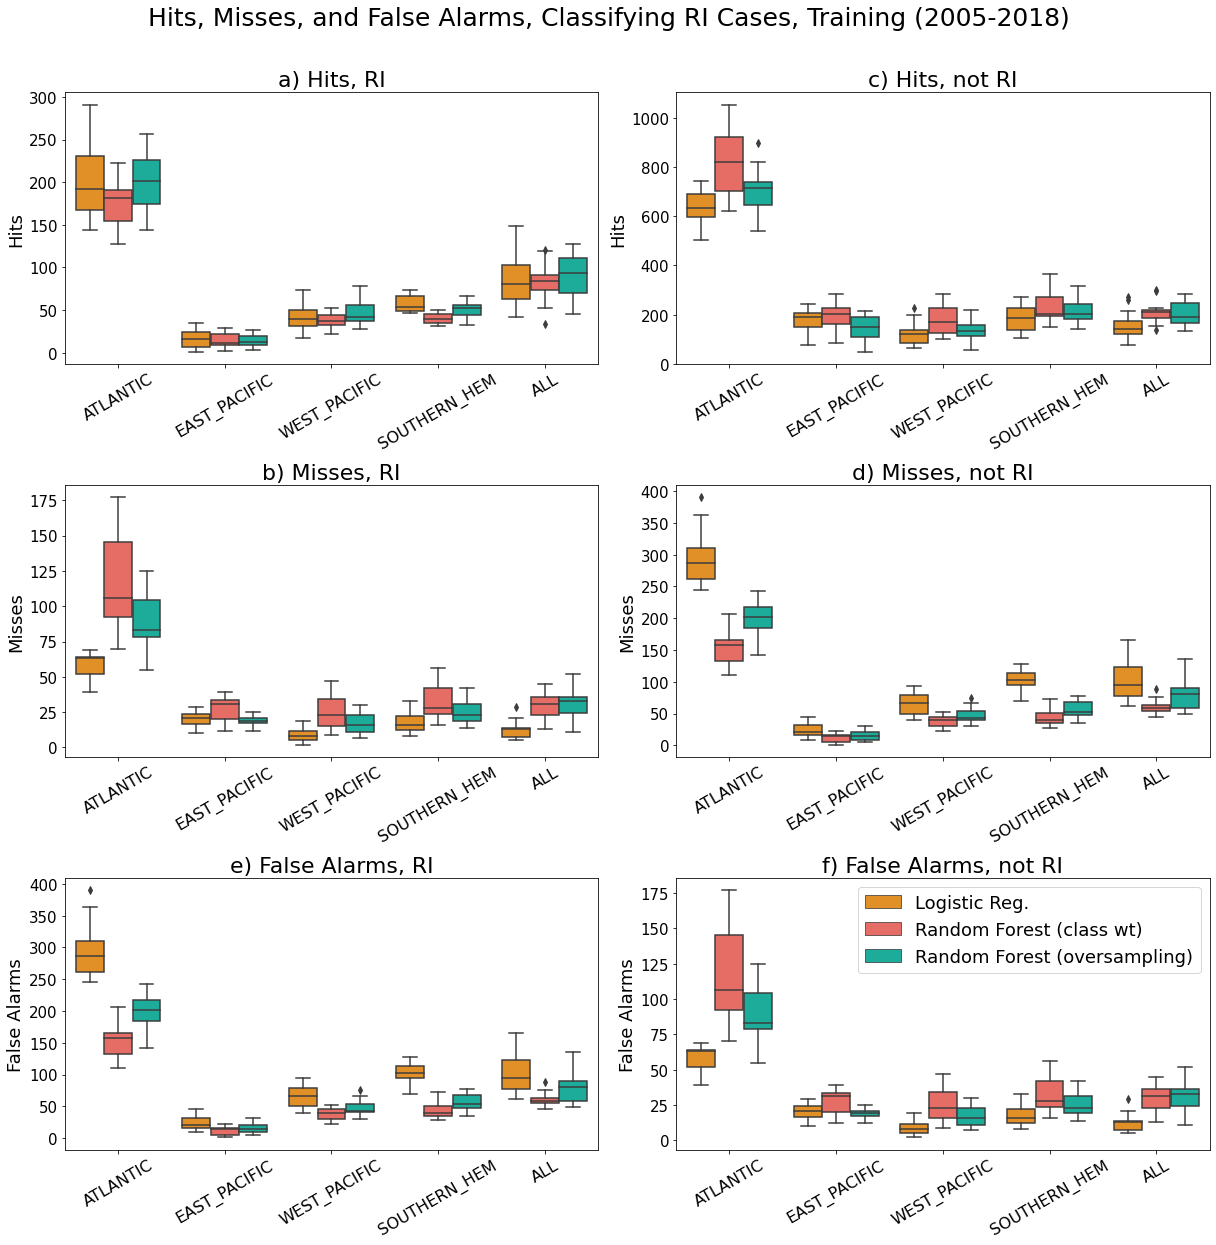

In [25]:
fig2,((ax2a,ax2b),(ax2c,ax2d),(ax2e,ax2f)) = plt.subplots(3,2,figsize=(17,17))
sns.boxplot(data=cm_plt_total.xs('RI').sort_values(['BASIN','Model']).reset_index(),x='BASIN',y='Hits',hue='Model',ax=ax2a)
ax2a.set_ylabel('Hits',fontsize=18)
ax2a.get_legend().remove()
# ax6a.legend(fontsize=12)
ax2a.set_xticklabels(basin_ALL,fontsize=16,rotation=30)
ax2a.set_title('a) Hits, RI',fontsize=22)
ax2a.set_xlabel(None)
# ax6a.set_ylim([0,1])
ax2a.tick_params(axis='y',labelsize=15)
#
sns.boxplot(data=cm_plt.xs('RI').sort_values(['BASIN','Model']).reset_index(),x='BASIN',y='Misses',hue='Model',ax=ax2c)
ax2c.set_ylabel('Misses',fontsize=18)
ax2c.legend(fontsize=12)
ax2c.get_legend().remove()
ax2c.set_xticklabels(basin_ALL,fontsize=16,rotation=30)
ax2c.set_title('b) Misses, RI',fontsize=22)
ax2c.set_xlabel(None)
# ax6c.set_ylim([0,1])
ax2c.tick_params(axis='y',labelsize=15)
#
sns.boxplot(data=cm_plt.xs('not RI').sort_values(['BASIN','Model']).reset_index(),
            x='BASIN',y='Hits',hue='Model',ax=ax2b)
ax2b.set_ylabel('Hits',fontsize=18)
ax2b.legend(fontsize=12)
ax2b.get_legend().remove()
ax2b.set_xticklabels(basin_ALL,fontsize=16,rotation=30)
ax2b.set_title('c) Hits, not RI',fontsize=22)
ax2b.set_xlabel(None)
ax2b.tick_params(axis='y',labelsize=15)
# ax6b.set_ylim([0,1])
#
sns.boxplot(data=cm_plt.xs('not RI').sort_values(['BASIN','Model']).reset_index(),
            x='BASIN',y='Misses',hue='Model',ax=ax2d)
ax2d.set_ylabel('Misses',fontsize=18)
# ax6d.legend(fontsize=18)
ax2d.get_legend().remove()
ax2d.set_xticklabels(basin_ALL,fontsize=16,rotation=30)
ax2d.set_title('d) Misses, not RI',fontsize=22)
ax2d.set_xlabel(None)
ax2d.tick_params(axis='y',labelsize=15)
# ax6d.set_ylim([0,1])
#
sns.boxplot(data=cm_plt.xs('RI').sort_values(['BASIN','Model']).reset_index(),
            x='BASIN',y='False Alarms',hue='Model',ax=ax2e)
ax2e.set_ylabel('False Alarms',fontsize=18)
#ax6e.legend(fontsize=18)
ax2e.get_legend().remove()
ax2e.set_xticklabels(basin_ALL,fontsize=16,rotation=30)
ax2e.set_title('e) False Alarms, RI',fontsize=22)
ax2e.set_xlabel(None)
ax2e.tick_params(axis='y',labelsize=15)
# ax6e.set_ylim([0,1])
#
sns.boxplot(data=cm_plt.xs('not RI').sort_values(['BASIN','Model']).reset_index(),
            x='BASIN',y='False Alarms',hue='Model',ax=ax2f)
ax2f.set_ylabel('False Alarms',fontsize=18)
ax2f.legend(fontsize=18)
ax2f.set_xticklabels(basin_ALL,fontsize=16,rotation=30)
ax2f.set_title('f) False Alarms, not RI',fontsize=22)
ax2f.set_xlabel(None)
ax2f.tick_params(axis='y',labelsize=15)
# ax6f.set_ylim([0,1])
#
fig2.suptitle('Hits, Misses, and False Alarms, Classifying RI Cases, Training (2005-2018)',fontsize=25,y=1.015)
fig2.tight_layout()
#
fig2.savefig(fig_dir_save+'HIT_MISS_FA_TRAINING.png',format='png',dpi=350,bbox_inches='tight')
fig2.savefig(fig_dir_save+'HIT_MISS_FA_TRAINING.pdf',format='pdf',bbox_inches='tight')

##### Load precision vs recall curves

In [32]:
p_vs_r_RF = pd.read_csv(fpath_load+'RF/Prec_vs_recall'+RF_path_suff)
p_vs_r_RF['Model'] = 'Random Forest (class wt)'
#
p_vs_r_RF_over = pd.read_csv(fpath_load+'RF/Prec_vs_recall'+RF_path_suff_ov)
p_vs_r_RF_over['Model'] = 'Random Forest (oversampling)'
#
p_vs_r_LR = pd.read_csv(fpath_load+'LOGISTIC/Prec_vs_recall'+LR_path_suff)
p_vs_r_LR['Model'] = 'Logistic Reg.'
#
prec_vs_rec = pd.concat([p_vs_r_RF,p_vs_r_RF_over,p_vs_r_LR])

##### Get performance diagram curves from precision vs recall data

/local/home/mmcgraw/ML_for_TC_RI/utils/SHIPS_plotting.py:214: UserWarning: The following kwargs were not used by contour: 'axes'
  plt.contourf(success_ratio_matrix, pod_matrix, csi_matrix,
/local/home/mmcgraw/ML_for_TC_RI/utils/SHIPS_plotting.py:229: UserWarning: The following kwargs were not used by contour: 'axes'
  bias_contour_object = plt.contour(
/local/home/mmcgraw/ML_for_TC_RI/utils/SHIPS_plotting.py:214: UserWarning: The following kwargs were not used by contour: 'axes'
  plt.contourf(success_ratio_matrix, pod_matrix, csi_matrix,
/local/home/mmcgraw/ML_for_TC_RI/utils/SHIPS_plotting.py:229: UserWarning: The following kwargs were not used by contour: 'axes'
  bias_contour_object = plt.contour(
/local/home/mmcgraw/ML_for_TC_RI/utils/SHIPS_plotting.py:214: UserWarning: The following kwargs were not used by contour: 'axes'
  plt.contourf(success_ratio_matrix, pod_matrix, csi_matrix,
/local/home/mmcgraw/ML_for_TC_RI/utils/SHIPS_plotting.py:229: UserWarning: The following kwargs we

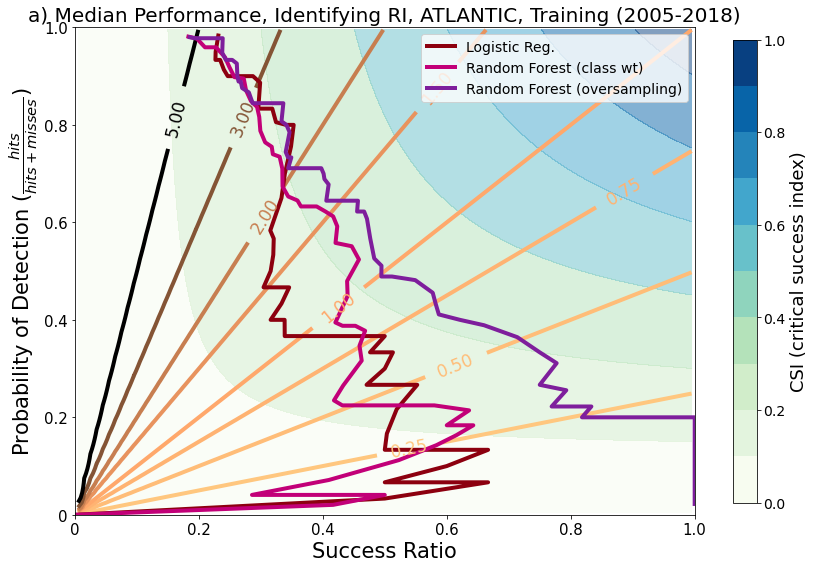

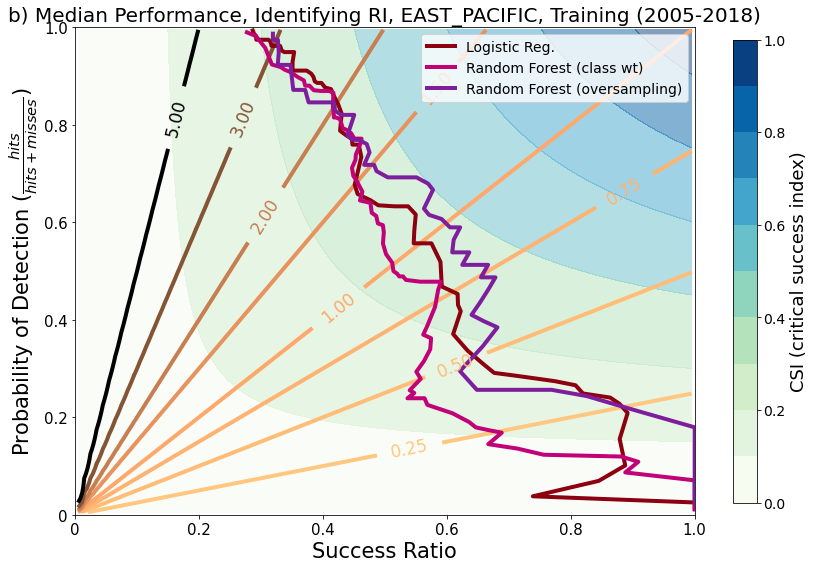

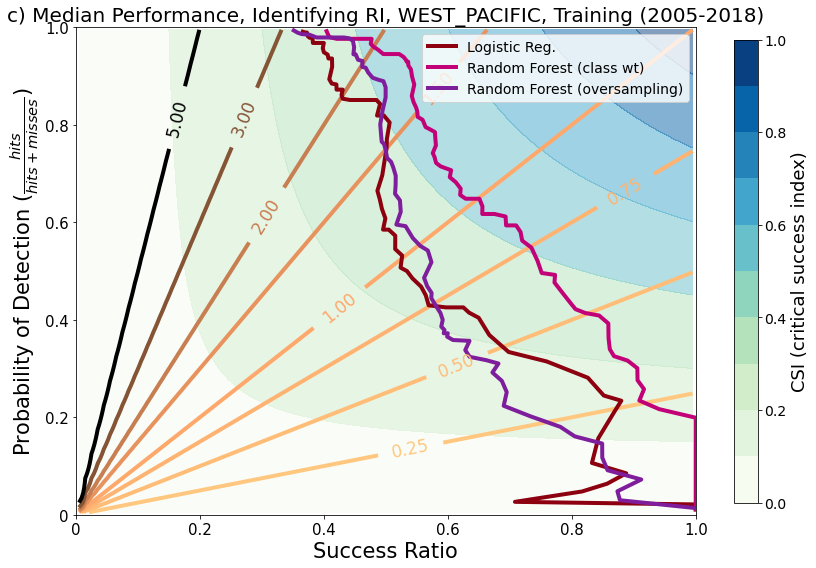

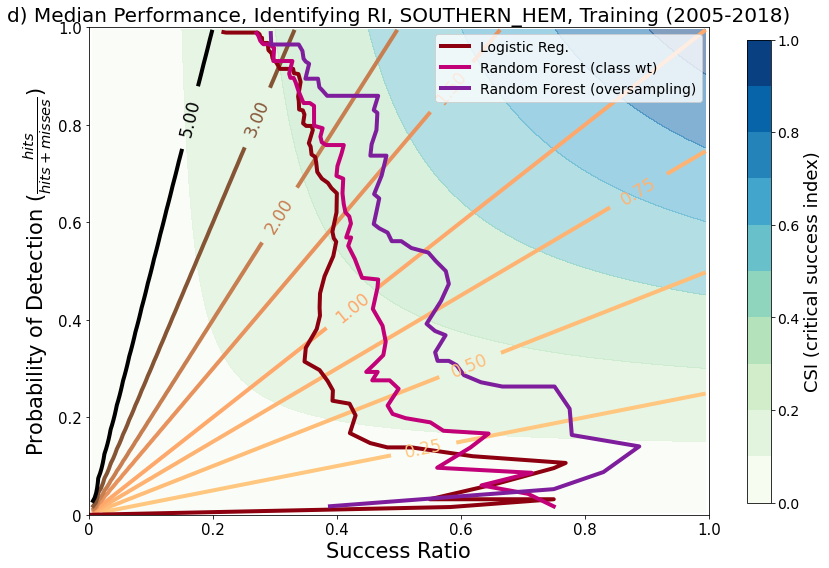

In [49]:
pd_curves = SHIPS_ML_model_funcs.calculate_PD_curves(prec_vs_rec)
metric_plt = 'median'
basin_use = ['ATLANTIC','EAST_PACIFIC','WEST_PACIFIC','SOUTHERN_HEM']
basin_label = ['a)','b)','c)','d)']
for ibasin in np.arange(0,len(basin_use)):
    basin_sel = basin_use[ibasin]
    basin_lett = basin_label[ibasin]
    fig3,ax3 = plt.subplots(1,1,figsize=(12,8))
    SHIPS_plotting.make_performance_diagram_background(ax3)
    SHIPS_plotting.plot_PD_curves_compare_models(prec_vs_rec,ax3,basin_sel,metric_plt)
    ax3.set_title('{lett} Median Performance, Identifying RI, {basin}, Training (2005-2018)'.format(
        lett=basin_lett,basin=basin_sel),fontsize=20)
    fig3.tight_layout()
    fig3.savefig(fig_dir_save+'PD_curves_{basin}_TRAINING.png'.format(basin=basin_sel),format='png',dpi=350,bbox_inches='tight')
    fig3.savefig(fig_dir_save+'PD_curves_{basin}_TRAINING.pdf'.format(basin=basin_sel),format='pdf',bbox_inches='tight')